# 0. SETUP

## 0.1 Imports


In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from A2C_continuous import A2C
from tqdm import tqdm
import os
%load_ext autoreload
%autoreload 2

# Agent 5 (K = 1 | n = 1)

## 5.1 PARAMETERS SETUP


In [1]:
# utils functions 
def set_seed(seed):
    torch.manual_seed(seed) # pytorch random seed
    np.random.seed(seed) # numpy random seed

def getTrajectory():
    # create a new sample environment to get new random parameters
    env = gym.make("InvertedPendulum-v4", max_episode_steps=1000) ## Continuous case
    states = []
    # get an initial state
    state, info = env.reset(seed=40) # Seed n°40 allows to have the same sufficiently long trajectory across runs 
    states.append(state)
    done = False
    # play one episode
    done = False
    for i in range(5):
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(0) # only pushes left (0 is left, 1 is right)
        states.append(state)
    while not done:
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(1) # only pushes left (0 is left, 1 is right)
        states.append(state)
        done = terminated or truncated
        
    env.close()
    return states

# HYPERPARAMETERS
# environment hyperparams
n_steps = 500000
n_envs = 1
n_steps_per_update = 1
n_updates = n_steps // (n_steps_per_update*n_envs)
evaluation_interval = 20000//(n_steps_per_update*n_envs) # evaluate the agent every 20k steps
n_eval_runs = 10 # how many evaluation runs to do each 20k steps 
n_evaluations = n_updates // evaluation_interval

# Aggregate parameters
n_seeds = 3 # number of random seeds for the aggregation of plots
agents_seeds = [10, 42, 81] # Arbitrary seeds for the agents

# agent hyperparams
gamma = 0.99  # discount factor
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 1e-5
critic_lr = 1e-3
stochasticity_bool = False
stochastic_reward_probability = 0.9
# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

# SEED
# Set a seed value
seed_value = 50
set_seed(seed_value)

# ENVIRONMENT
id_agent = "5" # ID of the Agent for the report [1:6]
envs = []
for i in range(n_envs):
    env = gym.make("InvertedPendulum-v4") ## Continuous case
    envs.append(env)

env_eval = gym.make("InvertedPendulum-v4") ## Continuous case
obs_shape = env_eval.observation_space.shape[0]
action_space_dims = 1 ## Continuous case ==> 1 dimension of action space: continuous force between [-3, 3] Newton

# DEVICE
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
else:
    device = torch.device("cpu")

# AGENT
#All observations start in state (0.0, 0.0, 0.0, 0.0) with a uniform noise in the 
#range of [-0.01, 0.01] added to the values for stochasticity.
agent = A2C(obs_shape, action_space_dims, device, critic_lr, actor_lr, n_envs) 


NameError: name 'torch' is not defined

## 5.2 AGENT TRAINING

In [ ]:
# LOGGED VARIABLES

# per seed
critic_losses = np.zeros((n_updates+1, n_seeds))
actor_losses = np.zeros((n_updates+1, n_seeds))
entropies = np.zeros((n_updates+1, n_seeds))
values = [[] for _ in range(n_seeds)] # logs the values of the agent on the fixed trajectory
evaluation_returns_seeds = [[] for _ in range(n_seeds)]

# per worker (not used in the plots)
episode_returns = [[] for _ in range(n_envs)] # logs the returns per episode per worker
steps_episodes = [[] for _ in range(n_envs)] # logs the steps taken in each episode per worker


fixed_trajectory = getTrajectory()

for s, agent_seed in enumerate(agents_seeds):
    print(f"Running seed {agent_seed} for agent {s}")
    agent = A2C(obs_shape, action_space_dims, device, critic_lr, actor_lr, n_envs)

    # COUNTERS
    steps = 0
    steps_workers = [0] * n_envs
    ep_counter = 0
    ep_reward = [0] * n_envs

    # VARIABLE INITIALIZATION
    is_truncated = [False] * n_envs #creates a list of n_envs elements, all set to False
    is_terminated = [False] * n_envs #creates a list of n_envs elements, all set to False
    states = []

    set_seed(agent_seed)
    for i in range(n_envs):
        state, info = envs[i].reset(seed=agent_seed)  #only use the seed when resetting the first time
        states.append(state)


    # use tqdm to get a progress bar for training
    for steps in tqdm(range(n_updates+1)):
            

        # reset lists that collect experiences of a n_steps_per_update
        n_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
        n_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
        # don't take mask and reward gradient
        masks = torch.ones(n_steps_per_update, n_envs, device=device,requires_grad = False)
        n_rewards = torch.zeros(n_steps_per_update, n_envs, device=device,requires_grad = False)
        end_states = [[] for _ in range(n_envs)] # get a list for each env ex : [[], [], []]
        end_states_idx = [[0] for _ in range(n_envs)] # get a list for each env ex : [[0], [0], [0]]

        # play n_steps_per_update to collect data
        for step in range(n_steps_per_update):
            entropy = [0] * n_envs
            for env_idx in range(n_envs):
                # select an action A_{t} using S_{t} as input for the agent, get action and values Vt
                action, action_log_probs, V_t, entropy[env_idx] = agent.select_action(states[env_idx], bool_greedy=False)

                # ensure no grad is taken in the step
                with torch.no_grad():
                    # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
                    states[env_idx], reward, is_terminated[env_idx], is_truncated[env_idx], infos = envs[env_idx].step(
                        action.cpu().numpy()
                    )
                    steps_workers[env_idx] += 1
                if stochasticity_bool:
                    # introduce stochasticity in the reward
                    if np.random.rand() < stochastic_reward_probability:
                        reward = 0

                ep_reward[env_idx] += reward # increase episode return
                mask = not is_terminated[env_idx] # define mask for bootstrapping

                # log the value, reward and action log prob of the last step
                n_value_preds[step][env_idx] = torch.squeeze(V_t)
                n_rewards[step][env_idx] = torch.tensor(reward, device=device)
                n_action_log_probs[step][env_idx] = action_log_probs

                # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
                masks[step][env_idx] = torch.tensor(mask) # allows for correct bootstrapping
                
                # reset environment if truncated or terminated
                if is_terminated[env_idx] or is_truncated[env_idx]:
                    states_tensor = torch.tensor(states[env_idx], device=device) # Transform the last state reached (S_t+n) to a tensor
                    end_states[env_idx].append(states_tensor)
                    end_states_idx[env_idx].append(step)
                    states[env_idx], info = envs[env_idx].reset() # do not use the seed when resetting again
                    ep_counter += 1
                    steps_episodes[env_idx].append(steps_workers[env_idx])
                    episode_returns[env_idx].append(ep_reward[env_idx])
                    ep_reward[env_idx] = 0

        
        for env_idx in range(n_envs):
            # if statement to make sure we don't append the end state twice
            if not is_terminated[env_idx] and not is_truncated[env_idx]:
                states_tensor = torch.tensor(states[env_idx], device=device) # Transform the last state reached (S_t+n) to a tensor
                end_states[env_idx].append(states_tensor)
                end_states_idx[env_idx].append(step)

        # calculate the losses for actor and critic
        critic_loss, actor_loss = agent.get_losses(
            n_rewards,
            n_action_log_probs,
            n_value_preds,
            entropy,
            masks,
            gamma,
            end_states,
            end_states_idx
        )

        # update the actor and critic networks
        agent.update_parameters(critic_loss, actor_loss)


        # log the losses and entropy
        critic_losses[steps, s] = critic_loss.detach().cpu().numpy()
        actor_losses[steps, s] = actor_loss.detach().cpu().numpy()
        entropies[steps, s] = sum(entropy) / len(entropy)


        #After every 20k steps, evaluate the performance of your agent by running it for 10 episodes with a greedy action policy (without noise)
        #on a newly initialized environment and plotting the evaluation statistics below.
        with torch.no_grad(): # No need to store gradients in the evaluation
            if steps % evaluation_interval == 0:
                print("EVALUATION")
                # evaluate
                returns = []
                episode_lengths = []
                for i in range(n_eval_runs):
                    # Only use the seed when resetting at the beginning to ensure the states will follow the same initialization at every evalutaion step
                    if i == 0:
                        state, info = env_eval.reset(seed = agent_seed)
                        value = []
                        for state_traj in fixed_trajectory:
                            _, _, V_t, _ = agent.select_action(state_traj, bool_greedy=False)
                            value.append(V_t)
                        values[s].append(value)
                        
                    else:
                        state, info = env_eval.reset()
                    episode_return = 0
                    episode_length = 0
                    while True:
                        action, _, _, _ = agent.select_action(state,bool_greedy=True)
                        state, reward, terminated, truncated, info = env_eval.step(action.cpu().numpy())
                        episode_return += reward
                        episode_length += 1
                        if terminated or truncated:
                            break
                    returns.append(episode_return)
                    episode_lengths.append(episode_length)  
                evaluation_returns_seeds[s].append(np.mean(returns))


# Logging variables for each agent
values_agent_5 = values.copy()
critic_losses_agent_5 = critic_losses.copy()
actor_losses_agent_5 = actor_losses.copy()
entropies_agent_5 = entropies.copy()
evaluation_returns_seeds_agent_5 = evaluation_returns_seeds.copy()
                





Running seed 10 for agent 0


  0%|          | 55/250001 [00:00<07:36, 547.53it/s]

EVALUATION
[56.0, 60.0, 63.0, 90.0, 37.0, 40.0, 39.0, 33.0, 34.0, 43.0]


  2%|▏         | 5442/250001 [00:04<03:22, 1209.81it/s]


KeyboardInterrupt: 

## 5.3 PLOTTING

In [ ]:
# Aggregate function for plotting the 3 seeds together
def aggregate_plot(y1,y2,y3):
    """
    Aggregates three input curves by computing the element-wise minimum, maximum, and average.

    Parameters:
    y1, y2, y3: np.ndarray
        Input arrays representing the three curves to be aggregated. Each array should have the same shape.

    Returns:
    y_min, y_max, y_avg: np.ndarray
        The element-wise minimum / maximum / average of the three input curves.
    """

    # Compute minimum and maximum curves
    y_min = np.minimum(np.minimum(y1, y2), y3)
    y_max = np.maximum(np.maximum(y1, y2), y3)

    # Compute average curve
    y_avg = (y1 + y2 + y3) / 3

    return y_min, y_max, y_avg

rolling_length = 30 # Rolling length for the convolution

# Arrays for the value function trajectories
values_arr = np.array(values) # Transforming the list to a numpy array ==> Values_arr of size (n_seeds, n_eval_done, steps_in_trajectory, 1)
values_sq = np.squeeze(values_arr) # Now of size (n_seeds, n_eval_done, steps_in_trajectory)
n_eval_done = values_sq.shape[1] # Number of evaluations done 
steps_in_trajectory = values_sq.shape[2] # Amount of steps in the trajectories of the value function
n_traj = 4 # Amount of value function trajectories to be plotted

# The code below is to select n_traj evenly spaced trajectories to plot between the first and last evaluation
if n_eval_done >= n_traj:
    idx_traj = np.linspace(0, n_eval_done - 1, n_traj, dtype='int') # Selecting n_traj trajectories evenly spaced between the first and last
else:
    idx_traj = np.arange(n_eval_done) # in case there are less evaluations than trajectories to plot, plot all evaluations

n_traj = len(idx_traj) # No matter how many trajectories where found, n_traj is updated to the actual length of the idx_traj
val_array = np.zeros((n_seeds, n_traj, steps_in_trajectory)) # Array to store the values of the selected trajectories
val_array = values_sq[:,idx_traj] # of size n_seeds, n_traj, steps_in_trajectory => contains only the values of the selected trajectories

traj_aggregates = np.zeros((n_seeds, n_traj, steps_in_trajectory)) # Will receive the values of y_min, y_max and y_avg for each of the n_traj for each seed


# Creating the lists for the aggregation
critic_y =[[] for _ in range(n_seeds)]
actor_y =[[] for _ in range(n_seeds)]
entropy_y =[[] for _ in range(n_seeds)]
evaluation_returns_seeds = np.array(evaluation_returns_seeds)


# Aggregating the losses and entropy while performing convolution
for s, agent_seed in enumerate(agents_seeds):
    critic_y[s] = (
        np.convolve(np.array(critic_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length)
    actor_y[s] = (
        np.convolve(np.array(actor_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length)
    entropy_y[s] = (
        np.convolve(np.array(entropies[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    
# Building the y_min, y_max and y_avg for each of the plots
critic_y_min, critic_y_max, critic_y_avg = aggregate_plot(critic_y[0],critic_y[1],critic_y[2])
actor_y_min, actor_y_max, actor_y_avg = aggregate_plot(actor_y[0],actor_y[1],actor_y[2])
entropy_y_min, entropy_y_max, entropy_y_avg = aggregate_plot(entropy_y[0],entropy_y[1],entropy_y[2])
reward_y_min, reward_y_max, reward_y_avg = aggregate_plot(evaluation_returns_seeds[0], evaluation_returns_seeds[1], evaluation_returns_seeds[2])

# x values for the plots
critic_x = np.arange(0, critic_y_min.shape[0])
actor_x = np.arange(0, actor_y_min.shape[0]) # Not necessary
entropy_x = np.arange(0, entropy_y_min.shape[0]) # Not necessary
reward_x = np.arange(0, reward_y_min.shape[0])
traj_x = np.arange(0, steps_in_trajectory)
#ep_return_x = np.arange(0, ep_return_y_min.shape[0])
for j in range(n_traj): # Storing the y_min, y_max and y_avg of each of the n_traj trajectories
    traj_aggregates[0,j], traj_aggregates[1,j], traj_aggregates[2,j], = aggregate_plot(val_array[0][j], val_array[1][j], val_array[2][j])

""" Plotting the losses, entropy and returns"""
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))
fig.suptitle(f"Agent {id_agent} | Steps per update: {n_steps_per_update} | Workers: {n_envs} | Steps: {n_steps//1000}k | Stochasticity: {stochasticity_bool} | SEEDS: {agents_seeds}", x=0.5, fontsize = 12)

# Critic loss
axs[0, 0].fill_between(critic_x,critic_y_min, critic_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[0, 0].plot(critic_x, critic_y_avg, color='red', label='Average Curve')
axs[0, 0].set_title('Critic Loss', fontweight='bold')
axs[0, 0].set_yscale('log')  # Set log scale for the y-axis
axs[0, 0].set_xlabel("Number of updates")

# Actor loss
axs[0, 1].fill_between(actor_x,actor_y_min, actor_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[0, 1].plot(actor_x, actor_y_avg, color='red', label='Average Curve')
axs[0, 1].set_title('Actor Loss', fontweight='bold')
axs[0, 1].set_yscale('log')  # Set log scale for the y-axis
axs[0, 1].set_xlabel("Number of updates")

# Entropy
axs[1, 0].fill_between(entropy_x,entropy_y_min, entropy_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[1, 0].plot(entropy_x, entropy_y_avg, color='red', label='Average Curve')
axs[1, 0].set_title("Entropy", fontweight='bold')
axs[1, 0].set_xlabel("Number of updates")

# Evaluation rewards
axs[1, 1].fill_between(reward_x,reward_y_min, reward_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[1, 1].plot(reward_x, reward_y_avg, color='red', label='Average Curve')
axs[1, 1].set_title('Evaluation Returns', fontweight='bold')
axs[1, 1].set_xlabel("Evaluation rounds")

#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig(f'figures/Agent{id_agent}_Losses&Returns.png', bbox_inches='tight')
plt.show()


"""Plotting the value function along the predefined fixed trajectory"""

colors = ['blue', 'green', 'purple', 'orange', 'black', 'yellow', 'pink', 'brown', 'cyan', 'magenta']

plt.figure(figsize=(10, 6))

for j in range(len(idx_traj)):
    plt.fill_between(traj_x, traj_aggregates[0,j], traj_aggregates[1,j], color = colors[j], alpha=0.3, label='Min-Max Range')
    plt.plot(traj_x, traj_aggregates[2,j,:], color=colors[j], label=f"Evaluation {idx_traj[j]+1}")

plt.suptitle(f"Agent {id_agent} | Steps per update: {n_steps_per_update} | Workers: {n_envs} | Steps: {n_steps//1000}k | Stochasticity: {stochasticity_bool} | SEEDS: {agents_seeds}", x=0.5, fontsize = 12)
plt.title('Value Function on Fixed Trajectories', fontweight='bold')
plt.xlabel('Agent step during the evaluation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig(f'figures/Agent{id_agent}_Trajectories.png', bbox_inches='tight')
#plt.savefig(f'figures/Agent{id_agent}_Trajectories-&-{n_steps//1000}k_steps-&-{n_envs}_workers-&-{n_steps_per_update}_steps-per-update.png', bbox_inches='tight')
plt.show()

# ----- Below OLD PLotting - Kept in case useful when trying K =1 and then 6

## 3.1 OLD PLOTTING

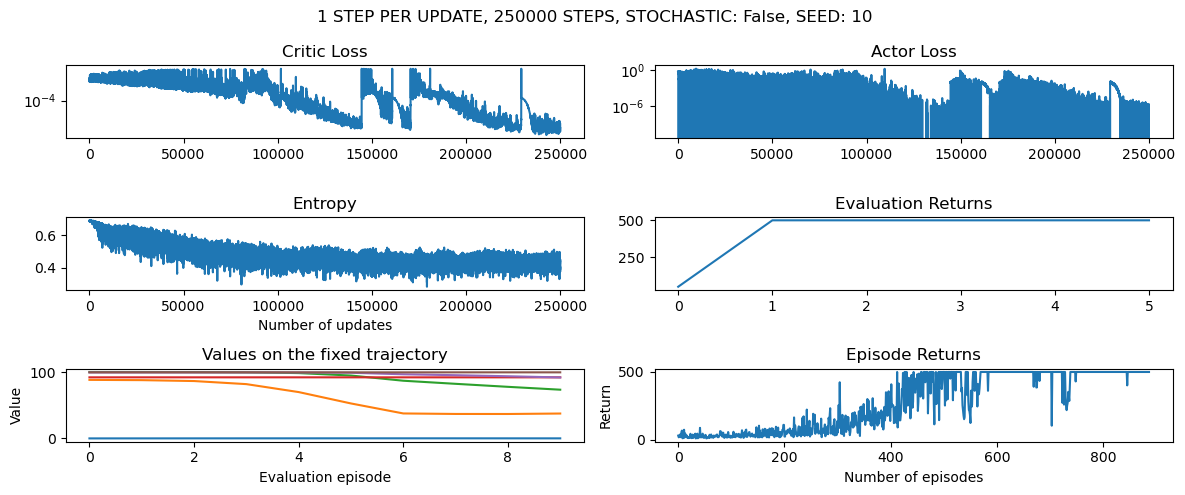

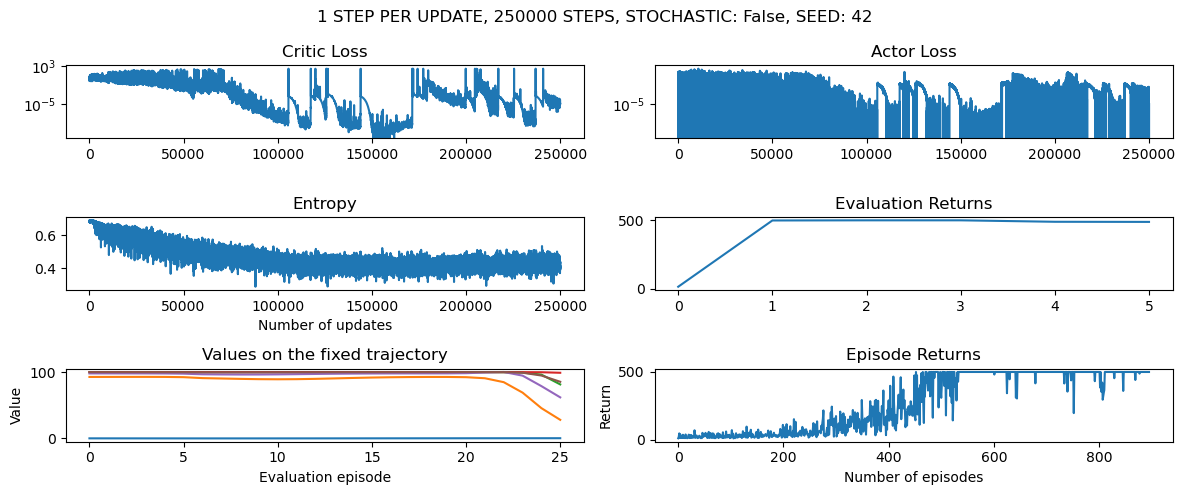

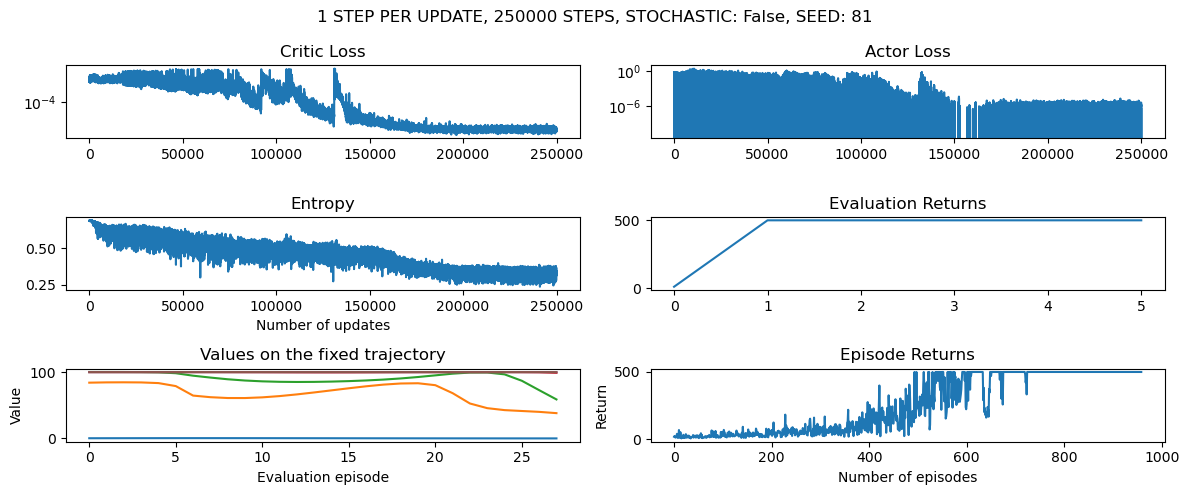

In [20]:
rolling_length = 30
for s, agent_seed in enumerate(agents_seeds):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 5))
    #set title of the plot
    fig.suptitle(f"{n_steps_per_update} STEP PER UPDATE, {n_steps} STEPS, STOCHASTIC: {stochasticity_bool}, SEED: {agent_seed}")

    #capped_loss = crit_loss[crit_loss < 1]
    critic_ma = (
        np.convolve(np.array(critic_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    axs[0, 0].plot(critic_ma)
    axs[0, 0].set_title('Critic Loss')
    axs[0, 0].set_yscale('log')  # Set log scale for the y-axis
 
    actor_ma = (
        np.convolve(actor_losses[:,s], np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    axs[0, 1].plot(actor_ma)
    axs[0, 1].set_title('Actor Loss')
    axs[0, 1].set_yscale('log')  # Set log scale for the y-axis


    # entropy
    axs[1][0].set_title("Entropy")
   
    entropy_moving_average = (
        np.convolve(np.array(entropies[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    axs[1][0].plot(entropy_moving_average)
    axs[1][0].set_xlabel("Number of updates")



    #axs[1, 1].plot(steps_episodes, episode_returns)
    #axs[1, 1].set_title('Episode Rewards')
    axs[1, 1].plot(evaluation_returns[s])
    axs[1, 1].set_title('Evaluation Returns')

    # plot the values of the agent on the fixed trajectory
    val_array = np.array(values[s])
    val_array = np.squeeze(val_array)

    for i in range(val_array.shape[0]):
        axs[2, 0].plot(val_array[i])
    axs[2, 0].set_title('Values on the fixed trajectory')
    axs[2, 0].set_xlabel('Evaluation episode')
    axs[2, 0].set_ylabel('Value')

    # plot the episode returns
    axs[2, 1].plot(episode_returns[s])
    axs[2, 1].set_title('Episode Returns')
    axs[2, 1].set_xlabel('Number of episodes')
    axs[2, 1].set_ylabel('Return')

    plt.tight_layout()
    plt.show()


[29, 46, 71, 93, 133, 151, 206, 273, 283, 294, 307, 380, 396, 442, 471, 491, 522, 536, 556, 567, 581, 603, 617, 660, 680, 691, 717, 754, 766, 794, 812, 850, 894, 903, 935, 946, 990, 1000, 1016, 1045, 1062, 1149, 1172, 1188, 1214, 1236, 1280, 1295, 1311, 1324, 1341, 1376, 1408, 1417, 1427, 1444, 1463, 1481, 1493, 1529, 1544, 1573, 1611, 1627, 1650, 1676, 1689, 1719, 1746, 1766, 1795, 1823, 1856, 1894, 1912, 1935, 1953, 1979, 2013, 2076, 2137, 2170, 2201, 2223, 2275, 2324, 2340, 2353, 2385, 2406, 2444, 2460, 2487, 2503, 2559, 2587, 2609, 2626, 2655, 2669, 2697, 2720, 2736, 2764, 2822, 2841, 2867, 2886, 2904, 2947, 2979, 3007, 3045, 3067, 3110, 3135, 3153, 3190, 3205, 3230, 3299, 3345, 3371, 3384, 3403, 3456, 3480, 3550, 3624, 3644, 3665, 3707, 3740, 3794, 3850, 3886, 3908, 3937, 3975, 4020, 4048, 4070, 4103, 4139, 4172, 4189, 4216, 4307, 4367, 4397, 4413, 4464, 4567, 4584, 4651, 4675, 4720, 4756, 4773, 4849, 4899, 4924, 4965, 5045, 5123, 5152, 5175, 5192, 5264, 5285, 5304, 5320, 5402, 54

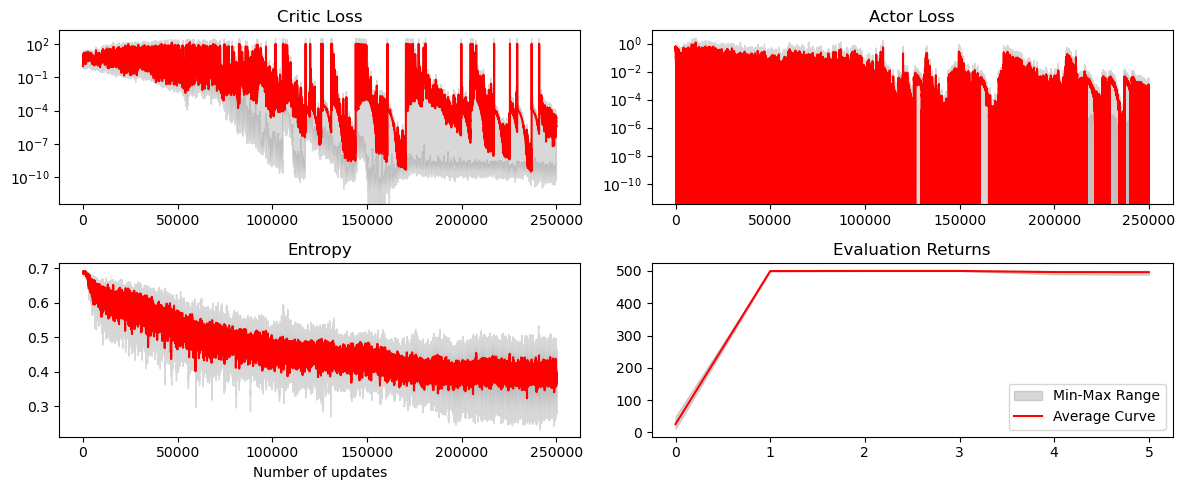

In [22]:
print(steps_episodes[0])
def aggregate_plot(y1,y2,y3):
    # Compute minimum and maximum curves
    y_min = np.minimum(np.minimum(y1, y2), y3)
    y_max = np.maximum(np.maximum(y1, y2), y3)

    # Compute average curve
    
    y_avg = (y1 + y2 + y3) / 3
    print(y_min.shape)
    print(y_avg.shape)

    return y_min, y_max, y_avg

rolling_length = 30
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
#fig.suptitle(f"{n_steps_per_update} STEP PER UPDATE, {n_steps} STEPS, STOCHASTIC: {stochasticity_bool}, SEED: {agent_seed}")
critic_y =[[] for _ in range(n_seeds)]
actor_y =[[] for _ in range(n_seeds)]
entropy_y =[[] for _ in range(n_seeds)]

for s, agent_seed in enumerate(agents_seeds):
    critic_y[s] = (
        np.convolve(np.array(critic_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length)
    actor_y[s] = (
        np.convolve(np.array(actor_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length)
    entropy_y[s] = (
        np.convolve(np.array(entropies[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    
evaluation_returns = np.array(evaluation_returns)
print(f"evaluation_returns: {evaluation_returns}")
critic_y_min, critic_y_max, critic_y_avg = aggregate_plot(critic_y[0],critic_y[1],critic_y[2])
actor_y_min, actor_y_max, actor_y_avg = aggregate_plot(actor_y[0],actor_y[1],actor_y[2])
entropy_y_min, entropy_y_max, entropy_y_avg = aggregate_plot(entropy_y[0],entropy_y[1],entropy_y[2])
reward_y_min, reward_y_max, reward_y_avg = aggregate_plot(evaluation_returns[0], evaluation_returns[1], evaluation_returns[2])
critic_x = np.arange(0, critic_y_min.shape[0])
actor_x = np.arange(0, actor_y_min.shape[0]) # Not necessary
entropy_x = np.arange(0, entropy_y_min.shape[0]) # Not necessary
reward_x = np.arange(0, reward_y_min.shape[0])

# Critic loss
axs[0, 0].fill_between(critic_x,critic_y_min, critic_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[0, 0].plot(critic_x, critic_y_avg, color='red', label='Average Curve')
axs[0, 0].set_title('Critic Loss')
axs[0, 0].set_yscale('log')  # Set log scale for the y-axis

# Actor loss
axs[0, 1].fill_between(actor_x,actor_y_min, actor_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[0, 1].plot(actor_x, actor_y_avg, color='red', label='Average Curve')
axs[0, 1].set_title('Actor Loss')
axs[0, 1].set_yscale('log')  # Set log scale for the y-axis

# Entropy
axs[1, 0].fill_between(entropy_x,entropy_y_min, entropy_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[1, 0].plot(entropy_x, entropy_y_avg, color='red', label='Average Curve')
axs[1, 0].set_title("Entropy")
axs[1, 0].set_xlabel("Number of updates")

# Episode rewards
axs[1, 1].fill_between(reward_x,reward_y_min, reward_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[1, 1].plot(reward_x, reward_y_avg, color='red', label='Average Curve')
axs[1, 1].set_title('Evaluation Returns')


""" TODO Add value plots"""


# Adjust layout
plt.tight_layout()
plt.legend()
# Show plot
plt.show()


# import matplotlib.pyplot as plt
# import numpy as np

# # Generate sample data for three curves
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.sin(x) + np.cos(x)

# # Plot each individual curve
# plt.plot(x, y1, label='Curve 1')
# plt.plot(x, y2, label='Curve 2')
# plt.plot(x, y3, label='Curve 3')

# # Compute minimum and maximum curves
# y_min = np.minimum(np.minimum(y1, y2), y3)
# y_max = np.maximum(np.maximum(y1, y2), y3)

# # Compute average curve
# y_avg = (y_min + y_max) / 2

# # Plot shaded area between minimum and maximum curves
# plt.fill_between(x, y_min, y_max, color='gray', alpha=0.3, label='Min-Max Range')

# # Plot average curve
# plt.plot(x, y_avg, color='red', label='Average Curve')

# # Add legend
# plt.legend()

# # Show plot
# plt.show()